In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
lstm_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/nasa/data.csv')

In [7]:
lstm_df

,latitude,longitude,brightness,satellite,bright_t31,frp,daynight,confidence
0,39.884,-78.246,300.3,T,284.0,10.4,N,24
1,18.639,-96.216,308.0,T,291.3,10.4,N,73
2,40.595,-105.702,303.1,T,278.5,23.4,N,53
3,40.696,-105.729,322.6,T,283.9,54.7,N,77
4,40.705,-105.718,321.3,T,282.8,49.1,N,39
...,...,...,...,...,...,...,...,...
8800,49.717,-101.740,304.7,A,291.5,5.8,D,58
8801,48.210,-114.115,308.5,A,296.3,16.3,D,41
8802,48.204,-114.139,307.0,A,296.5,12.1,D,41
8803,48.257,-114.390,314.1,A,297.8,23.0,D,71


In [8]:
def score_to_numeric(x):
    if x=='T':
        return 1
    if x=='A':
        return 0
def score_to_numeric2(x):
    if x=='N':
        return 1
    if x=='D':
        return 0

In [9]:
lstm_df['satellite'] = lstm_df['satellite'].apply(score_to_numeric)
lstm_df['daynight'] = lstm_df['daynight'].apply(score_to_numeric2)

In [10]:
lstm_df

,latitude,longitude,brightness,satellite,bright_t31,frp,daynight,confidence
0,39.884,-78.246,300.3,1,284.0,10.4,1,24
1,18.639,-96.216,308.0,1,291.3,10.4,1,73
2,40.595,-105.702,303.1,1,278.5,23.4,1,53
3,40.696,-105.729,322.6,1,283.9,54.7,1,77
4,40.705,-105.718,321.3,1,282.8,49.1,1,39
...,...,...,...,...,...,...,...,...
8800,49.717,-101.740,304.7,0,291.5,5.8,0,58
8801,48.210,-114.115,308.5,0,296.3,16.3,0,41
8802,48.204,-114.139,307.0,0,296.5,12.1,0,41
8803,48.257,-114.390,314.1,0,297.8,23.0,0,71


In [12]:
narray=np.array(lstm_df)
scaler = MinMaxScaler(feature_range=(0, 1))
narray = scaler.fit_transform(narray)
target=np.array(narray[1:,:])
target= np.c_[target[:, :2], target[:,-1]]
narray=narray[:-1,:]

In [13]:
print(target)
print(narray)

[[0.03310562 0.67600402 0.73      ]
 [0.71178634 0.57236813 0.53      ]
 [0.71490835 0.57207315 0.77      ]
 ...
 [0.94698773 0.48019272 0.41      ]
 [0.94862601 0.47745051 0.71      ]
 [0.94874965 0.47738496 0.68      ]]
[[6.89808661e-01 8.72328803e-01 1.45631068e-03 ... 6.86251221e-04
  1.00000000e+00 2.40000000e-01]
 [3.31056227e-02 6.76004020e-01 3.88349515e-02 ... 6.86251221e-04
  1.00000000e+00 7.30000000e-01]
 [7.11786344e-01 5.72368134e-01 1.50485437e-02 ... 1.54406525e-03
  1.00000000e+00 5.30000000e-01]
 ...
 [9.47173194e-01 4.80454923e-01 4.12621359e-02 ... 1.07556682e-03
  0.00000000e+00 4.10000000e-01]
 [9.46987728e-01 4.80192719e-01 3.39805825e-02 ... 7.98426901e-04
  0.00000000e+00 4.10000000e-01]
 [9.48626008e-01 4.77450509e-01 6.84466019e-02 ... 1.51767097e-03
  0.00000000e+00 7.10000000e-01]]


In [ ]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#narray = scaler.fit_transform(narray)
#traget = scaler.transform(target)

In [14]:
# extract indices for samples that have previous 4 hour data
lstm_valid_ind=[]
for ind,samples in lstm_df.iterrows():
    #if not(math.isnan(samples['air_data_t1']) or math.isnan(samples['air_data_t2']) or math.isnan(samples['air_data_t3']) or math.isnan(samples['air_data_t4'])):
    lstm_valid_ind.append(ind)

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset,target, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back+1, len(lstm_df)):
        a = dataset[(i-look_back-1):i-1, :]
        dataX.append(a)
        dataY.append(target[i-1])
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 10
X,Y= create_dataset(narray,target, look_back)

In [17]:
print(narray.shape)
print(X.shape)
print(Y.shape)
#print(X)
#print(Y)
#print(X)

(8804, 8)
(8794, 10, 8)
(8794, 3)


In [18]:
# split into train-test
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.30, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32,return_sequences=True, input_shape=(look_back,8)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(4))
model.add(Dense(30))
# model.add(Dense(30,kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(20))
model.add(Dense(3))
model.summary()
# optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel2.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            5248      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 16)            3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 8)             800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 30)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6

In [20]:
history=model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2, validation_data=(X_val,y_val), shuffle=True,callbacks=keras_callbacks)

Epoch 1/100
385/385 - 7s - loss: 0.0459 - val_loss: 0.0264
Epoch 2/100
385/385 - 5s - loss: 0.0256 - val_loss: 0.0250
Epoch 3/100
385/385 - 5s - loss: 0.0249 - val_loss: 0.0247
Epoch 4/100
385/385 - 6s - loss: 0.0245 - val_loss: 0.0255
Epoch 5/100
385/385 - 5s - loss: 0.0241 - val_loss: 0.0249
Epoch 6/100
385/385 - 5s - loss: 0.0239 - val_loss: 0.0233
Epoch 7/100
385/385 - 5s - loss: 0.0236 - val_loss: 0.0241
Epoch 8/100
385/385 - 6s - loss: 0.0233 - val_loss: 0.0246
Epoch 9/100
385/385 - 6s - loss: 0.0231 - val_loss: 0.0229
Epoch 10/100
385/385 - 6s - loss: 0.0230 - val_loss: 0.0233
Epoch 11/100
385/385 - 5s - loss: 0.0227 - val_loss: 0.0225
Epoch 12/100
385/385 - 6s - loss: 0.0226 - val_loss: 0.0224
Epoch 13/100
385/385 - 6s - loss: 0.0224 - val_loss: 0.0223
Epoch 14/100
385/385 - 6s - loss: 0.0224 - val_loss: 0.0237
Epoch 15/100
385/385 - 6s - loss: 0.0222 - val_loss: 0.0226
Epoch 16/100
385/385 - 5s - loss: 0.0222 - val_loss: 0.0224
Epoch 17/100
385/385 - 6s - loss: 0.0220 - val_lo

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

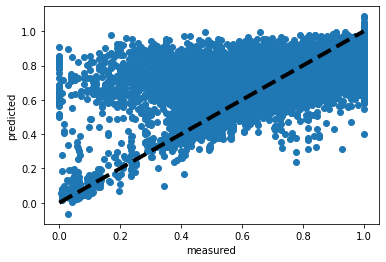

In [22]:
fig, ax = plt.subplots()
ax.scatter(trainY,trainPredict)
ax.plot([trainY.min(), trainY.max()], [trainY.min(), trainY.max()], 'k--', lw=4)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

In [23]:
testPredict[:,-1]

array([0.8899743 , 0.6871443 , 0.7571648 , ..., 0.87359375, 0.7384314 ,
       0.74728924], dtype=float32)

In [24]:
testY[:,-1]

array([1.  , 0.75, 0.96, ..., 0.67, 0.64, 1.  ])

In [26]:
np.savetxt('/content/drive/My Drive/Colab Notebooks/nasa/train file.csv', np.c_[trainY, trainPredict], fmt= '%.4f', delimiter=',')
np.savetxt('/content/drive/My Drive/Colab Notebooks/nasa/test file.csv', np.c_[testY, testPredict], fmt= '%.4f', delimiter=',')
np.savetxt('/content/drive/My Drive/Colab Notebooks/nasa/validation file.csv', np.c_[y_val, model.predict(X_val)], fmt= '%.4f', delimiter=',')